# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [5]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


Clear previously loaded data.
(49000, 32, 32, 3)
(49000,)
(1000, 32, 32, 3)
(1000,)
(1000, 32, 32, 3)
(1000,)


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

print(X_train_feats.shape)

print(X_val_feats.shape)

print(X_test_feats.shape)


# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [15]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        # 训练
        current_svm=LinearSVM()
        loss_hist=current_svm.train(X_train_feats, y_train, 
                              learning_rate=lr,
                              reg=rs,
                              num_iters=5000,
                              batch_size=200,
                              verbose=True)
        y_train_pred=current_svm.predict(X_train_feats)
        training_acc=np.mean(y_train_pred==y_train)
        
        y_val_pred=current_svm.predict(X_val_feats)
        val_acc=np.mean(y_val==y_val_pred)
        results[(lr,rs)]=(training_acc,val_acc)
        
        if val_acc>best_val:
            best_val=val_acc
            best_svm=current_svm
            
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 5000: loss 88.495626
iteration 100 / 5000: loss 86.940609
iteration 200 / 5000: loss 85.379629
iteration 300 / 5000: loss 83.880304
iteration 400 / 5000: loss 82.393602
iteration 500 / 5000: loss 80.940181
iteration 600 / 5000: loss 79.528870
iteration 700 / 5000: loss 78.123349
iteration 800 / 5000: loss 76.744975
iteration 900 / 5000: loss 75.413050
iteration 1000 / 5000: loss 74.089533
iteration 1100 / 5000: loss 72.816657
iteration 1200 / 5000: loss 71.532175
iteration 1300 / 5000: loss 70.292271
iteration 1400 / 5000: loss 69.092788
iteration 1500 / 5000: loss 67.898438
iteration 1600 / 5000: loss 66.730398
iteration 1700 / 5000: loss 65.577994
iteration 1800 / 5000: loss 64.463795
iteration 1900 / 5000: loss 63.380968
iteration 2000 / 5000: loss 62.280320
iteration 2100 / 5000: loss 61.243683
iteration 2200 / 5000: loss 60.199388
iteration 2300 / 5000: loss 59.183546
iteration 2400 / 5000: loss 58.192101
iteration 2500 / 5000: loss 57.221793
iteration 2600 / 5000: l

iteration 2000 / 5000: loss 8.999964
iteration 2100 / 5000: loss 8.999960
iteration 2200 / 5000: loss 8.999959
iteration 2300 / 5000: loss 8.999965
iteration 2400 / 5000: loss 8.999975
iteration 2500 / 5000: loss 8.999964
iteration 2600 / 5000: loss 8.999968
iteration 2700 / 5000: loss 8.999964
iteration 2800 / 5000: loss 8.999968
iteration 2900 / 5000: loss 8.999963
iteration 3000 / 5000: loss 8.999968
iteration 3100 / 5000: loss 8.999969
iteration 3200 / 5000: loss 8.999962
iteration 3300 / 5000: loss 8.999964
iteration 3400 / 5000: loss 8.999962
iteration 3500 / 5000: loss 8.999967
iteration 3600 / 5000: loss 8.999966
iteration 3700 / 5000: loss 8.999970
iteration 3800 / 5000: loss 8.999962
iteration 3900 / 5000: loss 8.999968
iteration 4000 / 5000: loss 8.999962
iteration 4100 / 5000: loss 8.999962
iteration 4200 / 5000: loss 8.999968
iteration 4300 / 5000: loss 8.999965
iteration 4400 / 5000: loss 8.999964
iteration 4500 / 5000: loss 8.999967
iteration 4600 / 5000: loss 8.999966
i

iteration 4600 / 5000: loss 9.000000
iteration 4700 / 5000: loss 9.000000
iteration 4800 / 5000: loss 9.000000
iteration 4900 / 5000: loss 8.999999
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.103633 val accuracy: 0.112000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.114000 val accuracy: 0.112000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.413000 val accuracy: 0.416000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.225000 val accuracy: 0.231000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.414939 val accuracy: 0.424000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.407000 val accuracy: 0.405000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.417592 val accuracy: 0.429000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.410939 val accuracy: 0.394000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.288102 val accuracy: 0.272000
best validation accuracy achieved during cross-validation: 0.429000


In [16]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.412


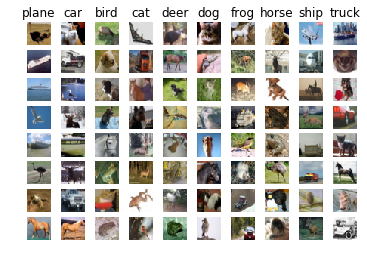

In [17]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

In [30]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim=200
num_classes = 10

best_acc=-1
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
# for hd in [200]:
#     for lr in [3e-1,1]:
#         for reg in [3e-4,1e-3,3e-3]:
#             net = TwoLayerNet(input_dim, hd, num_classes)
#             stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
#                         num_iters=3000, batch_size=300,
#                         learning_rate=lr, learning_rate_decay=0.99,
#                         reg=reg, verbose=True)

#             # Predict on the validation set
#             val_acc = (net.predict(X_val_feats)==y_val).mean()
#             print ("regularization=%f, lr = %f, hidden dim = %f, Valid_accuracy: %f" %(reg, lr, hd,val_acc))
#             if val_acc > best_acc:
#                 best_acc = val_acc
#                 best_net = net
                
# print('best validation accuracy achieved during cross-validation: %f' % best_acc)

for hidden_size in [hidden_dim]:
    for learning_rate in [1e-1,5e-1]:
        for learning_rate_decay in [0.999]:
            for reg in [3e-4,1e-3,3e-3]:
                net = TwoLayerNet(input_dim, hidden_dim, num_classes)
                # Train the network
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=3000, batch_size=500,
                            learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
                            reg=reg, verbose=True)

                # Predict on the validation set
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                print('hidden_size = %d,learning_rate = %f,learning_rate_decay = %f,reg = %f,Validation accuracy =%f '%(hidden_size,learning_rate,learning_rate_decay,reg,val_acc))
                if best_acc<val_acc:
                    best_acc = val_acc
                    best_net = net

print('best validation accuracy achieved during cross-validation: %f' % best_acc)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302513
iteration 200 / 3000: loss 2.151269
iteration 300 / 3000: loss 1.787463
iteration 400 / 3000: loss 1.598492
iteration 500 / 3000: loss 1.533048
iteration 600 / 3000: loss 1.452384
iteration 700 / 3000: loss 1.407212
iteration 800 / 3000: loss 1.376320
iteration 900 / 3000: loss 1.378551
iteration 1000 / 3000: loss 1.340687
iteration 1100 / 3000: loss 1.294811
iteration 1200 / 3000: loss 1.330880
iteration 1300 / 3000: loss 1.248184
iteration 1400 / 3000: loss 1.377133
iteration 1500 / 3000: loss 1.292776
iteration 1600 / 3000: loss 1.336846
iteration 1700 / 3000: loss 1.268102
iteration 1800 / 3000: loss 1.246101
iteration 1900 / 3000: loss 1.258125
iteration 2000 / 3000: loss 1.256179
iteration 2100 / 3000: loss 1.213842
iteration 2200 / 3000: loss 1.235922
iteration 2300 / 3000: loss 1.150951
iteration 2400 / 3000: loss 1.235752
iteration 2500 / 3000: loss 1.154652
iteration 2600 / 3000: loss 1.119029
iteration 270

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)